# Bone meshing example

This meshing example is prepared for the CINEMAX VI summer school, August 2021. The bone data is borrowed from the group of [Hanna Isaksson](https://portal.research.lu.se/portal/en/persons/hanna-isaksson(854a6054-1fbb-4a5f-a9a6-4d9e36f5204b).html) and will be introduced by Lorenzo Grassi on Wednesday morning.

The aim is to prooduce a mesh representing a segmentation of the image into air, cartilage, and bone. The mesh will be used for structural modelling. 

One way of solving this problem would be to triangulate the image domain, and assign every triangle to a class (air, cartilage, or bone) according to the mean image intensity inside the triangle. However, triangle edges would not be aligned with the imaged structures, and the interfaces between the materials would be jagged. We will therefore first detect the contours giving the interfaces between the materials, and then perform a constrained triangulation.

For CINEMAX summer school, we have prepared relavant functions in a Python module called meshing. You are encouraged to take a look at `meshing.py` for details on how meshing is computed - or for modifying the functions.

## Settting up

The provided meshing moduele requires the [triangle module](https://rufat.be/triangle). In addition, you will need numpy, matplotlib, scipy and [scikit-image](https://scikit-image.org/). 

In [2]:
%matplotlib notebook 
import meshing
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import skimage.measure
import skimage.io
import skimage

## Pre-processing
Loading, cropping, and smoothing an image. We would normally use a considerable amount of time investigating the data, checking the image type, artifacts, histogram etc. Here we only crop and slightly smooth the image.

<IPython.core.display.Javascript object>


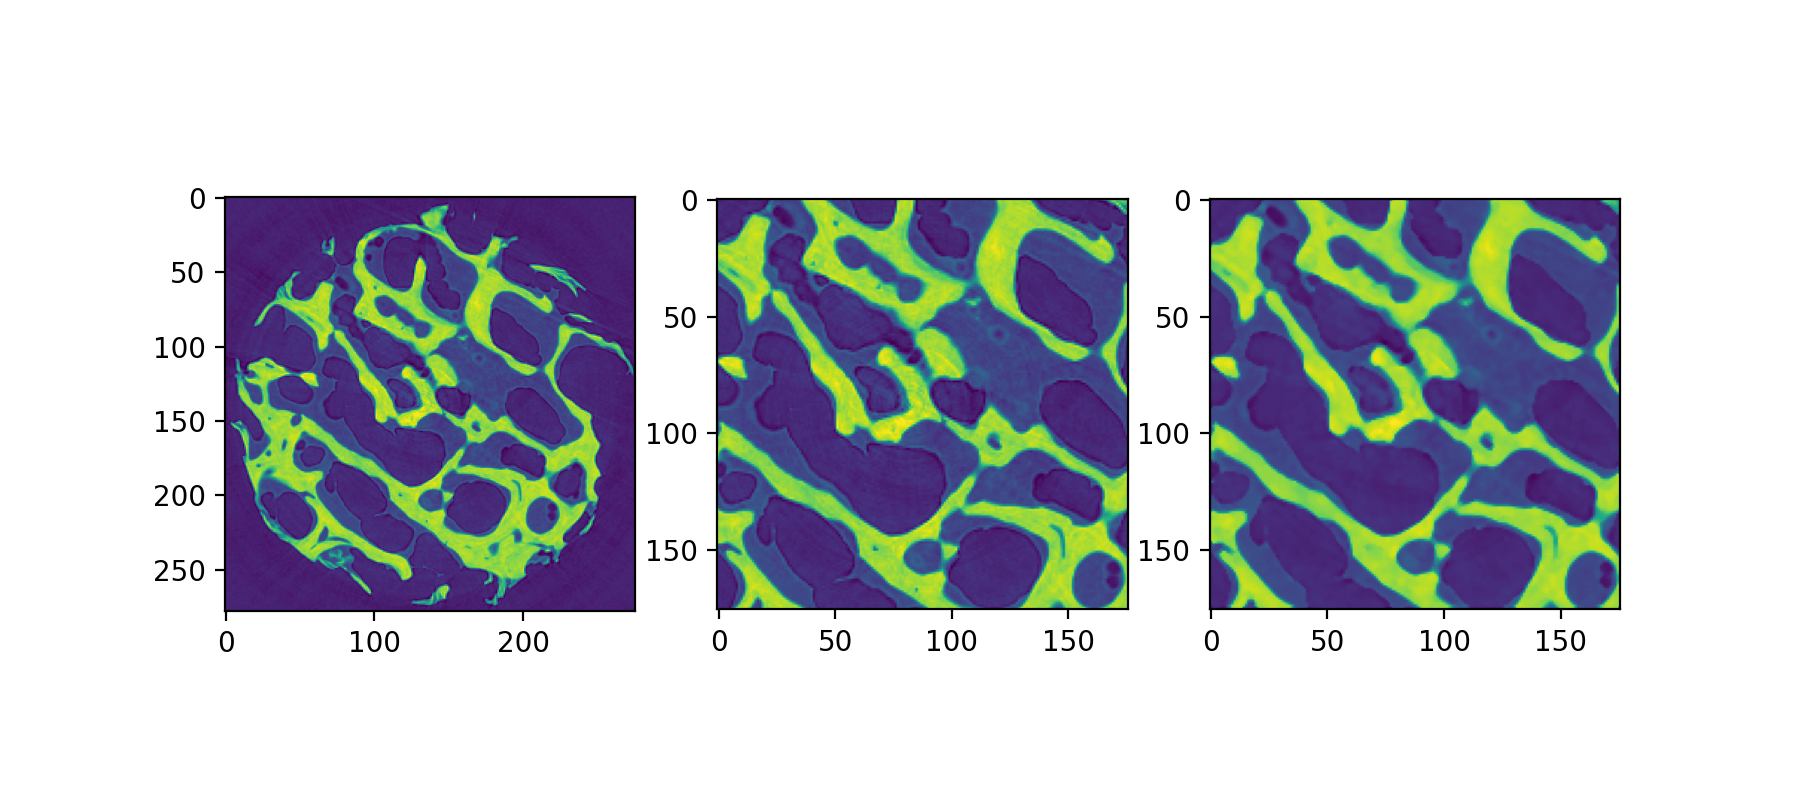

In [3]:
# Load image
image = skimage.io.imread('data/bone.png')

fig, ax = plt.subplots(1,3, figsize=(9, 4))
ax[0].imshow(image)

# Crop 
image = image[50:226,50:226]
ax[1].imshow(image)

# Smooth a bit
image = scipy.signal.medfilt(image, kernel_size=3)
ax[2].imshow(image)

plt.show()

## Try thresholding
The aim is to divide the image domain in three regions: air, cartilage, and bone. So this is a three-label problem, which is different from other examples where we worked with binary segmentation problems.


Test whether thresholding will yield a somehow good result. Also try choosing suitable thresholds.


<IPython.core.display.Javascript object>


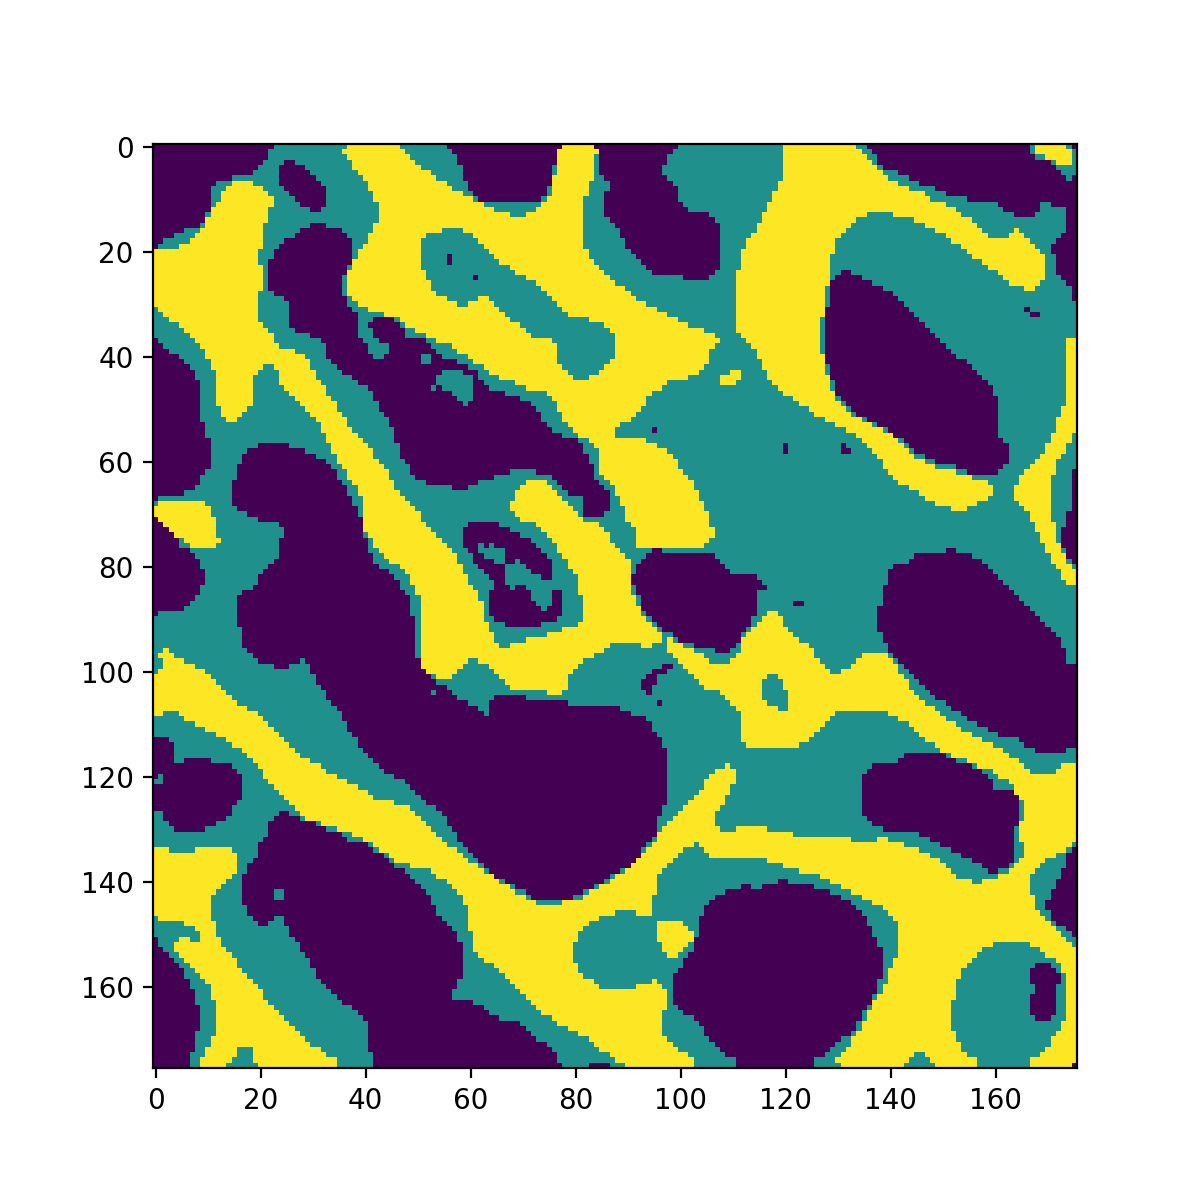

In [4]:
threshold_1 = 40 # air-cartilage threshold
threshold_2 = 140 # cartilage-bone threshold 

thresholded = (image > threshold_1).astype(int) + (image > threshold_2).astype(int)
figsize = (6,6)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(thresholded)
plt.show()

## Detect contours

Find iso-valued contours in a 2D array for a given level value. We use the marching squares (2D [marching cubes](https://en.wikipedia.org/wiki/Marching_cubes)) implementation from scikit image module. See [scikit-image documentation](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours) for more information on contour detection.

Make sure to understand the data structure returned by the function. Also zoom in the image to see the individual contour points.

Since we have three-label problem, we will detect contours for each of the two thresholds.

<IPython.core.display.Javascript object>


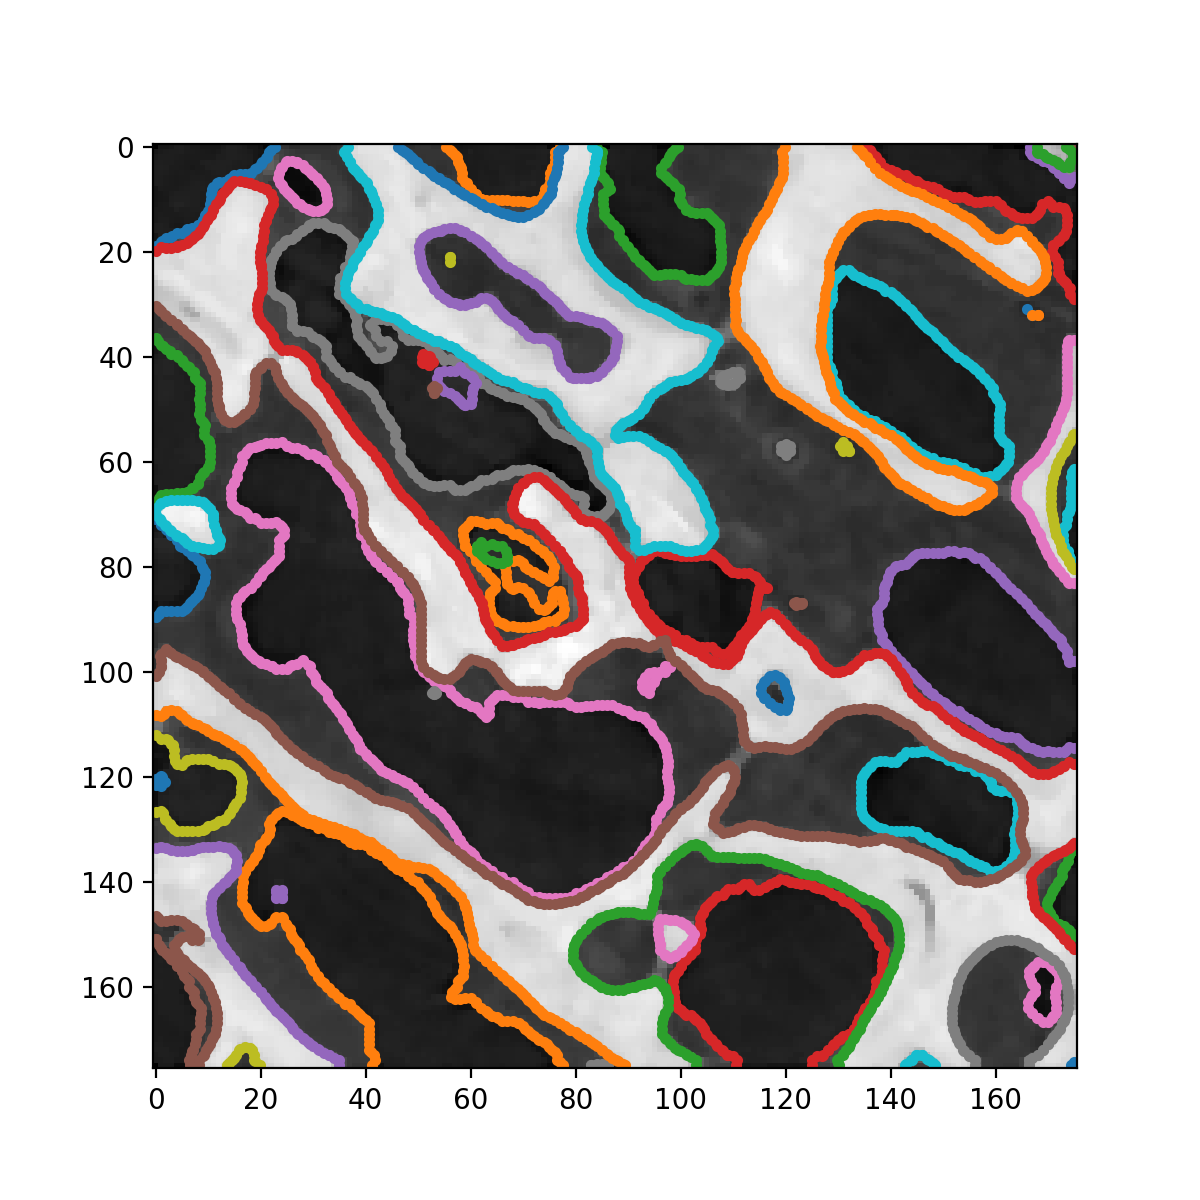

In [5]:
contours_1 = skimage.measure.find_contours(image, threshold_1)
contours_2 = skimage.measure.find_contours(image, threshold_2)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image,cmap=plt.cm.gray)
for c in contours_1 + contours_2:
    ax.plot(c[:,1], c[:,0],'.')
plt.show()

## Re-sample contours
Contours returned from marching squares are very dense; point distances are less than one pixel. This is usually too dense to be passed to the meshing algorithm. We thefore need to resample the contours with a larger point distance. The functionality for resampling (based on linear interpolation of point coordinates) is provided in the meshing module.

Additionally, for this three-label problem, the curves for the two thresholds may bet very close, or even interact. The subsequent triangulation will crash if there are curve intersections or other configuratioins which can not be handled. We therefore remove very small contours.

<IPython.core.display.Javascript object>


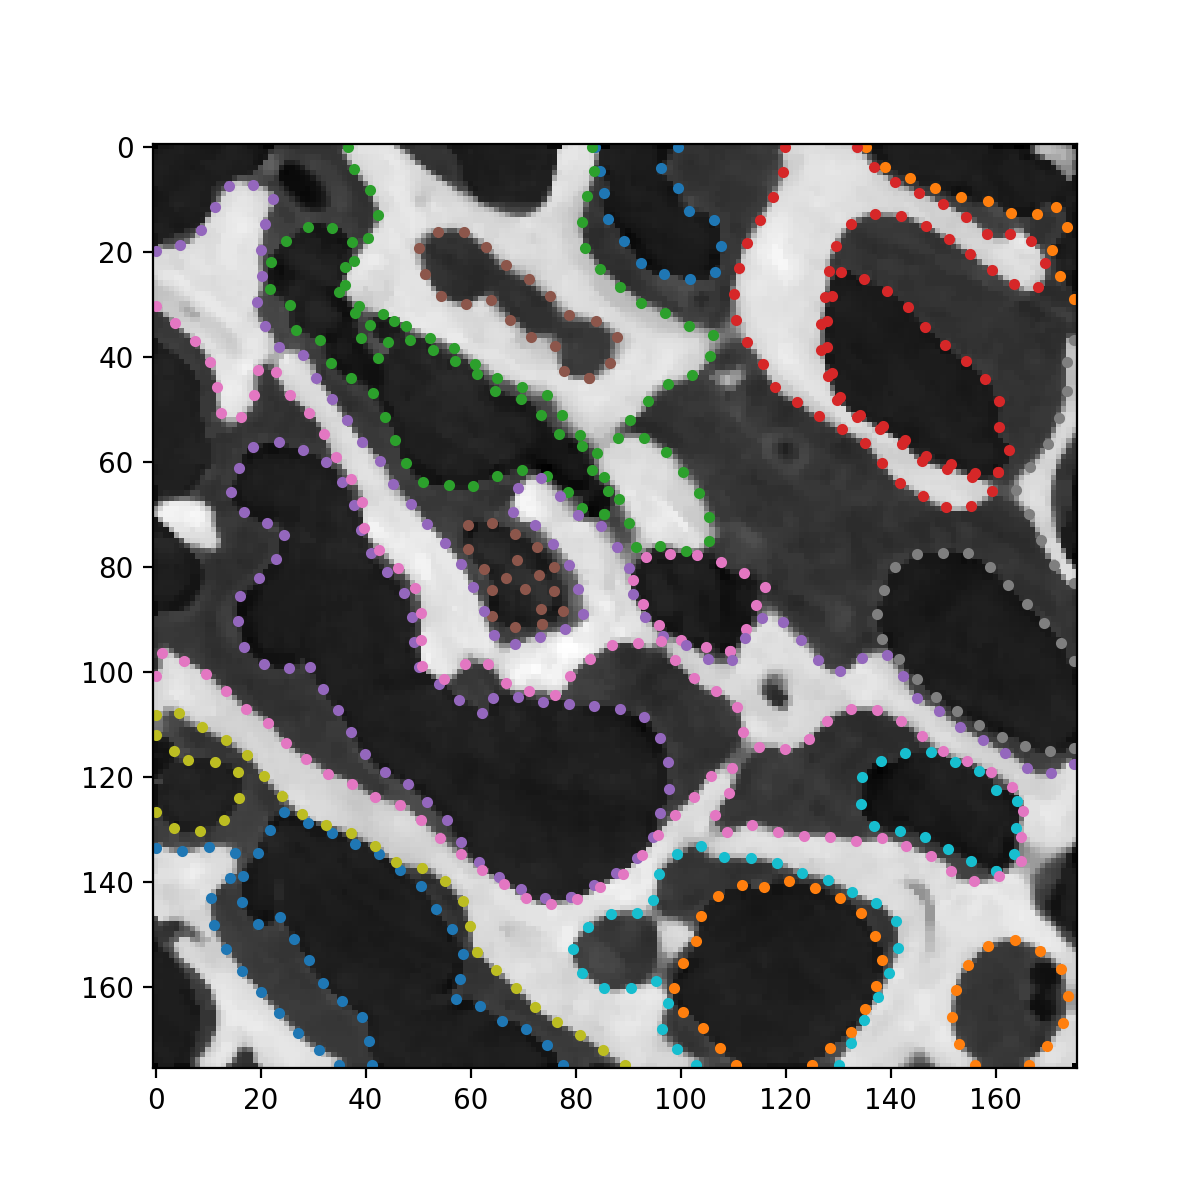

In [6]:
average_edge_length = 5 # desired average edge length on the curves
contours_1 = meshing.resample_contours(contours_1, average_edge_length)
contours_2 = meshing.resample_contours(contours_2, average_edge_length)

minimal_contour_size = 10 # smallest nr. vertices in the contour
contours_1  = meshing.remove_small_contours(contours_1, minimal_contour_size)
contours_2  = meshing.remove_small_contours(contours_2, minimal_contour_size)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image,cmap=plt.cm.gray)
for c in contours_1 + contours_2:
    ax.plot(c[:,1], c[:,0],'.')
plt.show()

## Collect vertices and edges of curve segments

We will subsequently use conforming constrained Dealuney triangulation frorm the triangle package which expects to be given constrains as vertex list and segment list. We therefore collect contour points in a vertex list, and create an edge list. The functionality for this is provided in meshing module. 

Make sure to understand the output data structure. Note that we now lose explicit information about the individual curve. Still, edges are oriented and always have the same materials on left/right side. 

We also add the contours for the two thresholds in a single vertex and edge list. Now we loose information on materials.

<IPython.core.display.Javascript object>


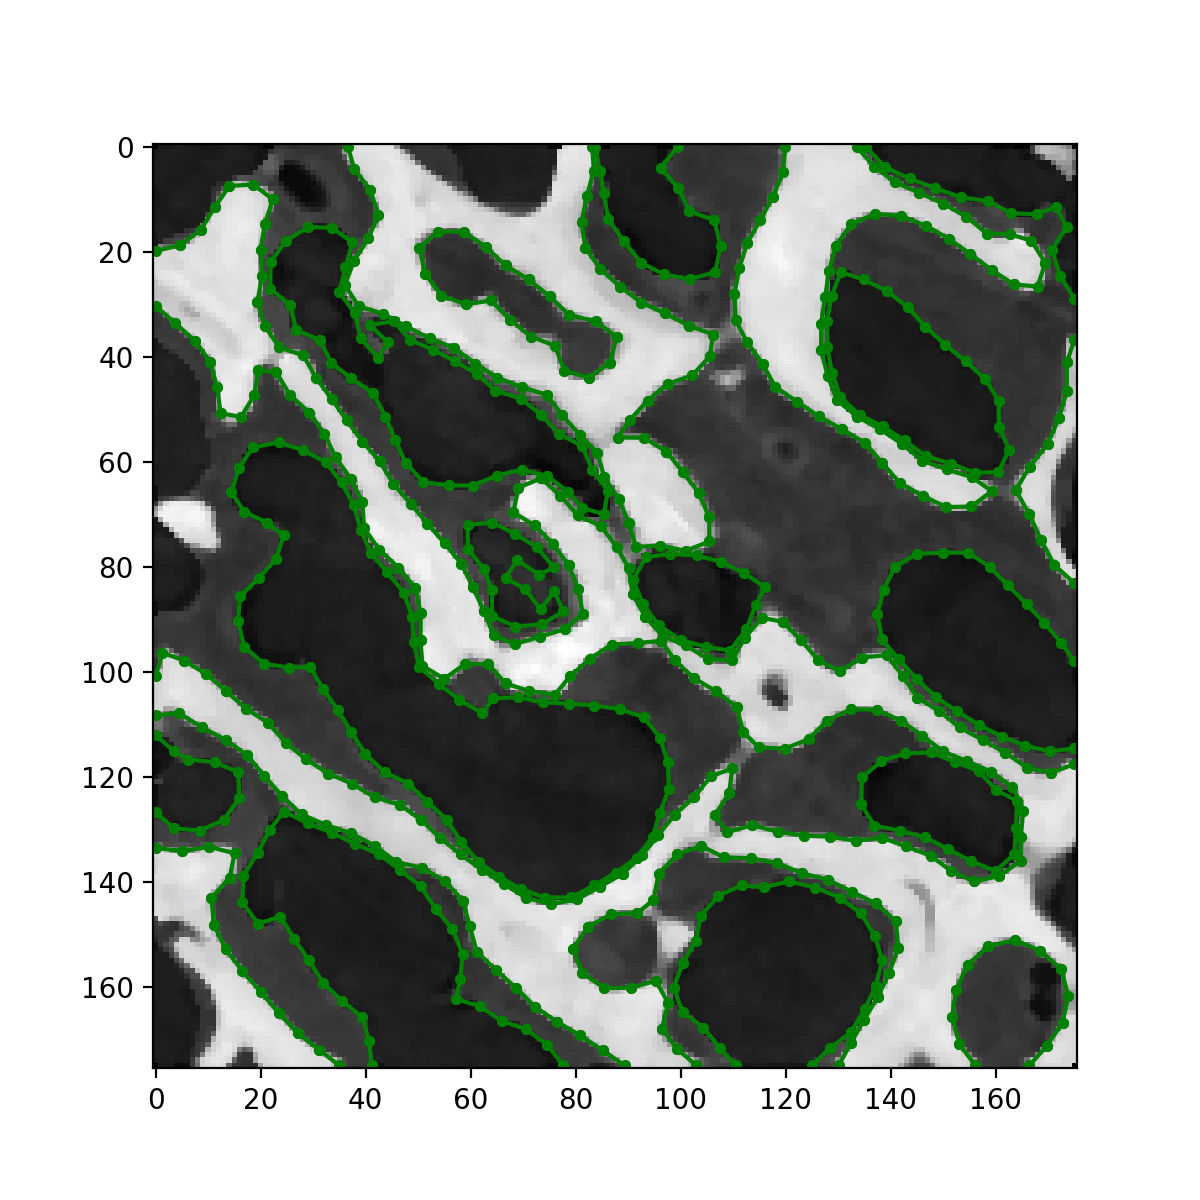

In [7]:
vertices_1, edges_1 = meshing.contours_to_segments(contours_1)
vertices_2, edges_2 = meshing.contours_to_segments(contours_2)

vertices = np.concatenate([vertices_1, vertices_2], axis=0)
edges_2 = edges_2 + vertices_1.shape[0]
edges = np.concatenate([edges_1, edges_2], axis=0)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image,cmap=plt.cm.gray)
for e in edges:
    ax.plot(vertices[e,1], vertices[e,0], '.g')
    ax.plot(vertices[e,1], vertices[e,0], '-g')
plt.show()

## Triangulate image domain

The meshing module provides a function for triangulation given segments and maximal area of the triangles. For computing the conforming constrained Delaunay triangulation module for meshing we rely on the functionality from [triangle package](https://rufat.be/triangle/), which in turn wraps around [Jonathan Richard Shewchuk’s mesh generator](http://www.cs.cmu.edu/~quake/triangle.html). 

The triangulation is constrained, i.e. the input segments are present in triangulation. The triangulation is conforming, i.e. vartices have been added to mantain the Delaunay property and the constraints on the minimum angle and maximum triangle area. See [Shewchuk's definitins](http://www.cs.cmu.edu/~quake/triangle.defs.html) for more informations. 

Note that an input segment may be broken into smaller parts.

<IPython.core.display.Javascript object>


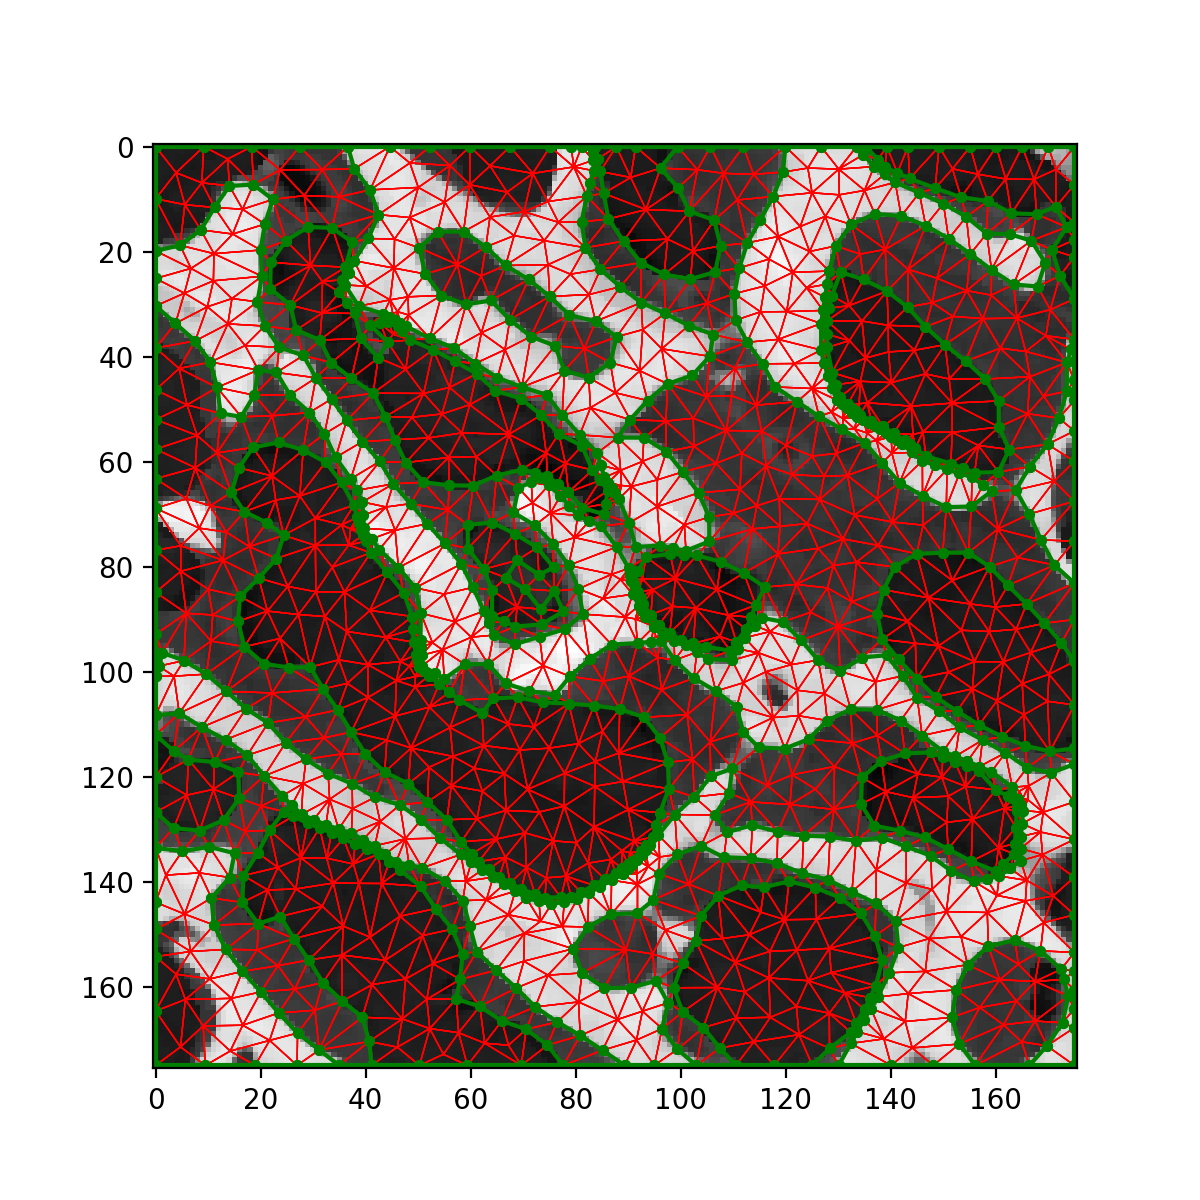

In [8]:
max_area = (average_edge_length**2) # desired maximal triangle area
vertices, triangles, edges = meshing.triangulate_domain(vertices, edges, max_area, image.shape)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(image,cmap=plt.cm.gray)
for t in triangles:
    tri = t[[0,1,2,0]]
    ax.plot(vertices[tri,1], vertices[tri,0], 'r', linewidth=0.5)
    ax.plot(vertices[tri,1], vertices[tri,0], 'r', linewidth=0.5)
for e in edges:
    ax.plot(vertices[e,1], vertices[e,0], '.g')
    ax.plot(vertices[e,1], vertices[e,0], '-g')
plt.show()

## Compute triangle labels from curves
We still need to determine a label for each triangle. For this, we might look at the imagee data, but our curves have been resampled, and some triangles might be assigned a wrong label and produce a jagged interface. We therefore re-use the oriented edges to obtain label information. The function probided by the meshing module lables triangles adjacent to edges, and propagates labels within one material using [breadth first search](https://en.wikipedia.org/wiki/Breadth-first_search) on triangles.   

<IPython.core.display.Javascript object>


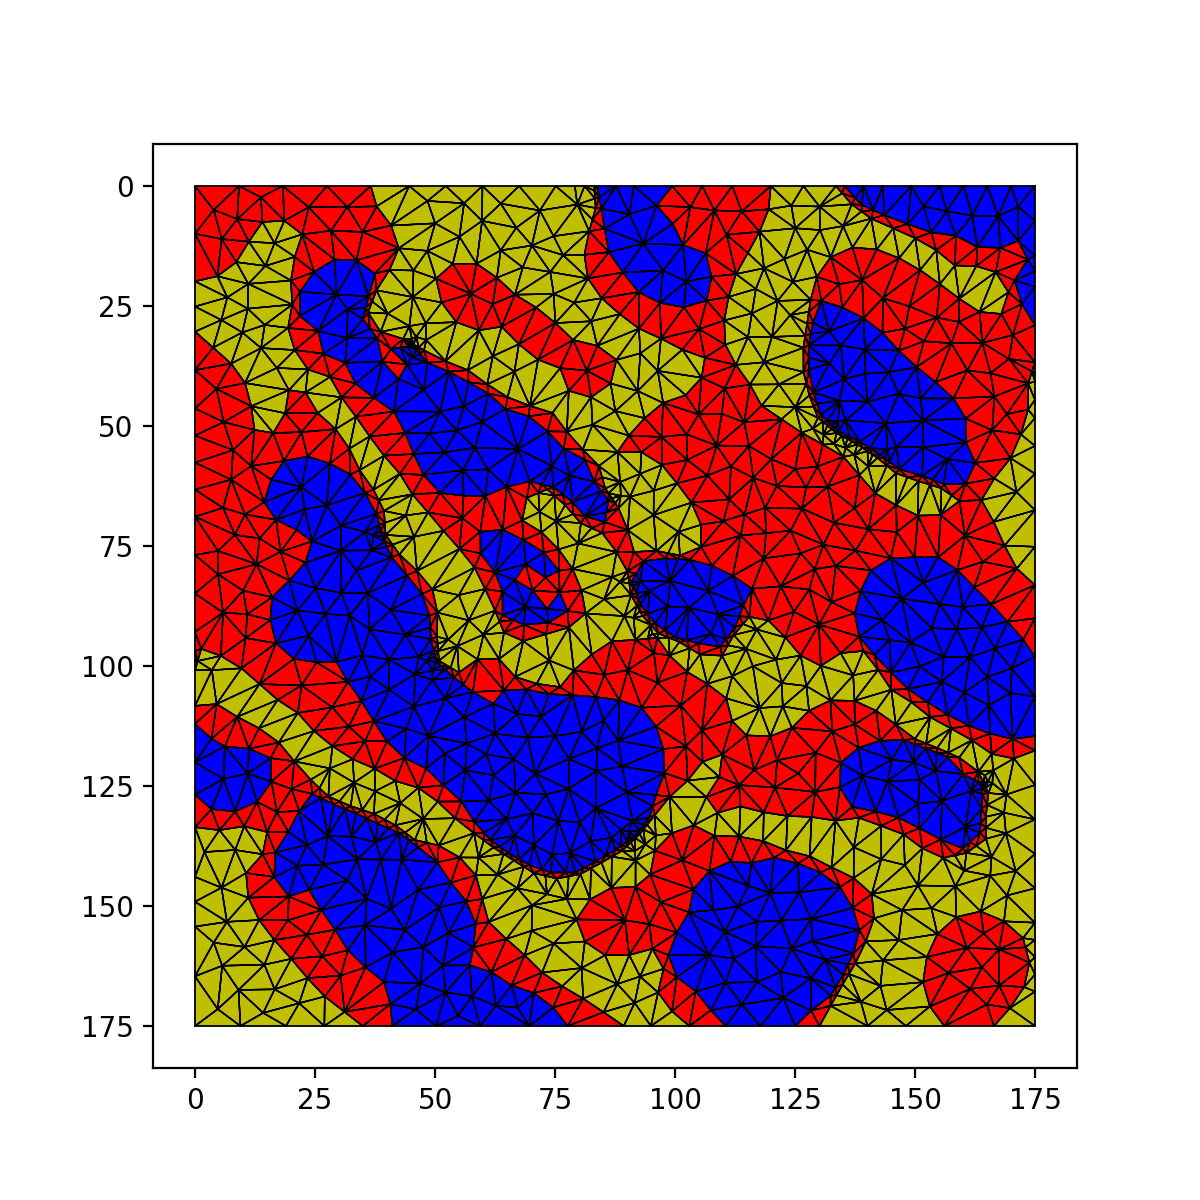

In [11]:
labels_1 = meshing.label_triangles_from_curves(vertices, triangles, edges_1, edges)
labels_2 = meshing.label_triangles_from_curves(vertices, triangles, edges_2, edges) + 1
labels = np.maximum(labels_1, labels_2)

colors = {-1: 'm', 0: 'b', 1: 'r', 2: 'y'}

fig, ax = plt.subplots(figsize=figsize)
for t, l in zip(triangles, labels):
    color = colors[l]
    ax.fill(vertices[t,1], vertices[t,0], color)
for t in triangles:
    tri = t[[0,1,2,0]]
    ax.plot(vertices[tri,1], vertices[tri,0], 'k', linewidth=0.5)
    ax.plot(vertices[tri,1], vertices[tri,0], 'k', linewidth=0.5)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.show()

## Save the mesh and triangle labels
The mesh information is saved in a text file as a vertex list, trianglee list, and label list.  

In [10]:
filename = 'out/bone_mesh.txt'
meshing.save_mesh(filename, vertices, triangles, labels)